In [1]:
# Fix for protobuf and TensorFlow warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppress TensorFlow warnings
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'  # Disable oneDNN custom operations

# Suppress protobuf warnings
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

2025-11-18 01:32:43.251330: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763429563.490009      48 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763429563.549344      48 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [2]:
# ============================================================================
# STEP 1: Load and Explore the Dataset
# ============================================================================

# Load CIFAR-10 dataset
# CIFAR-10 contains 60,000 32x32 color images in 10 classes
# 50,000 training images and 10,000 test images
(X_train_full, y_train_full), (X_test, y_test) = cifar10.load_data()

print("Dataset Shape Information:")
print(f"Training data shape: {X_train_full.shape}")
print(f"Training labels shape: {y_train_full.shape}")
print(f"Test data shape: {X_test.shape}")
print(f"Test labels shape: {y_test.shape}")

# CIFAR-10 class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck']


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 92s 1us/step
Dataset Shape Information:
Training data shape: (50000, 32, 32, 3)
Training labels shape: (50000, 1)
Test data shape: (10000, 32, 32, 3)
Test labels shape: (10000, 1)


In [3]:
# ============================================================================
# STEP 2: Data Preprocessing
# ============================================================================

# Feature Scaling: Normalize pixel values to [0, 1] range
# This helps the model converge faster during training
X_train_full = X_train_full.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

print("\nAfter normalization:")
print(f"Training data range: [{X_train_full.min()}, {X_train_full.max()}]")

# One-Hot Encoding: Convert class labels to binary class matrices
# Example: class 3 becomes [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
y_train_full = to_categorical(y_train_full, 10)
y_test = to_categorical(y_test, 10)

print(f"Labels after one-hot encoding shape: {y_train_full.shape}")

# Optional: Use a subset of training data for faster training
# Comment out these lines to use full dataset
SUBSET_SIZE = 40000  # Adjust this value as needed
X_train = X_train_full[:SUBSET_SIZE]
y_train = y_train_full[:SUBSET_SIZE]

# Create validation split from training data
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

print(f"\nFinal dataset sizes:")
print(f"Training set: {X_train.shape[0]}")
print(f"Validation set: {X_val.shape[0]}")
print(f"Test set: {X_test.shape[0]}")


After normalization:
Training data range: [0.0, 1.0]
Labels after one-hot encoding shape: (50000, 10)

Final dataset sizes:
Training set: 32000
Validation set: 8000
Test set: 10000


In [4]:
# ============================================================================
# STEP 3: Build Baseline Model
# ============================================================================

def create_baseline_model():
    """
    Simple baseline CNN model for comparison
    Architecture: 2 Conv layers + 1 Dense layer
    """
    model = models.Sequential([
        # First convolutional block
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
        layers.MaxPooling2D((2, 2)),
        
        # Second convolutional block
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        
        # Flatten and classify
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])
    return model

# Build and compile baseline model
baseline_model = create_baseline_model()
baseline_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("\n" + "="*70)
print("BASELINE MODEL ARCHITECTURE")
print("="*70)
baseline_model.summary()


I0000 00:00:1763429676.648019      48 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1763429676.648843      48 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5



BASELINE MODEL ARCHITECTURE


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       147,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 167,562 (654.54 KB)

 Trainable params: 167,562 (654.54 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
# Train baseline model
print("\nTraining Baseline Model...")
baseline_history = baseline_model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=64,
    validation_data=(X_val, y_val),
    verbose=1
)

# Evaluate baseline model
baseline_test_loss, baseline_test_acc = baseline_model.evaluate(X_test, y_test, verbose=0)
print(f"\nBaseline Model Test Accuracy: {baseline_test_acc*100:.2f}%")


Training Baseline Model...
Epoch 1/10


I0000 00:00:1763429680.469943     108 service.cc:148] XLA service 0x7c47d0009540 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1763429680.471531     108 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1763429680.471552     108 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1763429680.733406     108 cuda_dnn.cc:529] Loaded cuDNN version 90300


 50/500 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1745 - loss: 2.2136

I0000 00:00:1763429682.952682     108 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.3423 - loss: 1.8053 - val_accuracy: 0.5161 - val_loss: 1.3635
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5401 - loss: 1.2935 - val_accuracy: 0.5854 - val_loss: 1.1874
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6122 - loss: 1.1097 - val_accuracy: 0.6118 - val_loss: 1.1127
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6438 - loss: 1.0178 - val_accuracy: 0.6398 - val_loss: 1.0409
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6684 - loss: 0.9554 - val_accuracy: 0.6620 - val_loss: 0.9921
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7000 - loss: 0.8709 - val_accuracy: 0.6516 - val_loss: 1.0219
Epoch 7/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7165 - loss: 0.8192 - val_accuracy: 0.6743 - val_loss: 0.9555
Epoch 8/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7299 - loss: 0.7707 - val_accuracy: 0.6708 - val_

In [6]:
# ============================================================================
# STEP 4: Build Improved CNN Model
# ============================================================================

def create_improved_cnn():
    """
    Improved CNN model with multiple convolutional blocks,
    batch normalization, and dropout for better performance
    
    Architecture:
    - 3 Convolutional blocks with increasing filters (32->64->128)
    - Batch Normalization after each Conv layer for stable training
    - MaxPooling for spatial dimension reduction
    - Dropout layers to prevent overfitting
    - Dense layers for final classification
    """
    model = models.Sequential([
        # First Convolutional Block
        layers.Conv2D(32, (3, 3), padding='same', activation='relu', 
                     input_shape=(32, 32, 3)),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Second Convolutional Block
        layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Third Convolutional Block
        layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Flatten and Dense Layers
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        
        # Output Layer
        layers.Dense(10, activation='softmax')
    ])
    return model

In [7]:

# Build and compile improved model
improved_model = create_improved_cnn()

# Compile with Adam optimizer and categorical crossentropy loss
improved_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("\n" + "="*70)
print("IMPROVED MODEL ARCHITECTURE")
print("="*70)
improved_model.summary()


IMPROVED MODEL ARCHITECTURE


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 849,066 (3.24 MB)

 Trainable params: 847,402 (3.23 MB)

 Non-trainable params: 1,664 (6.50 KB)

In [8]:
# ============================================================================
# STEP 5: Train Improved Model with Callbacks
# ============================================================================

# Define callbacks for better training
# ReduceLROnPlateau: Reduce learning rate when validation loss plateaus
# EarlyStopping: Stop training when validation loss stops improving

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

print("\nTraining Improved Model...")
improved_history = improved_model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=[reduce_lr, early_stopping],
    verbose=1
)



Training Improved Model...
Epoch 1/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step - accuracy: 0.2684 - loss: 2.3401 - val_accuracy: 0.2660 - val_loss: 2.1471 - learning_rate: 0.0010
Epoch 2/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.4943 - loss: 1.4009 - val_accuracy: 0.5853 - val_loss: 1.1604 - learning_rate: 0.0010
Epoch 3/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.5971 - loss: 1.1418 - val_accuracy: 0.6659 - val_loss: 0.9282 - learning_rate: 0.0010
Epoch 4/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.6598 - loss: 0.9730 - val_accuracy: 0.6879 - val_loss: 0.8863 - learning_rate: 0.0010
Epoch 5/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.7014 - loss: 0.8711 - val_accuracy: 0.6771 - val_loss: 0.9075 - learning_rate: 0.0010
Epoch 6/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.7207 - loss: 0.8084 - val_accuracy: 0.7501 - val_loss: 0.7142 - learning_rate: 0.0010
Epoch 7/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accu

In [9]:
# ============================================================================
# STEP 6: Evaluate Models
# ============================================================================

# Evaluate improved model on test set
improved_test_loss, improved_test_acc = improved_model.evaluate(X_test, y_test, verbose=0)

print("\n" + "="*70)
print("FINAL RESULTS")
print("="*70)
print(f"Baseline Model Test Accuracy:  {baseline_test_acc*100:.2f}%")
print(f"Improved Model Test Accuracy:  {improved_test_acc*100:.2f}%")
print(f"Improvement: {(improved_test_acc - baseline_test_acc)*100:.2f}%")


FINAL RESULTS
Baseline Model Test Accuracy:  67.66%
Improved Model Test Accuracy:  83.65%
Improvement: 15.99%


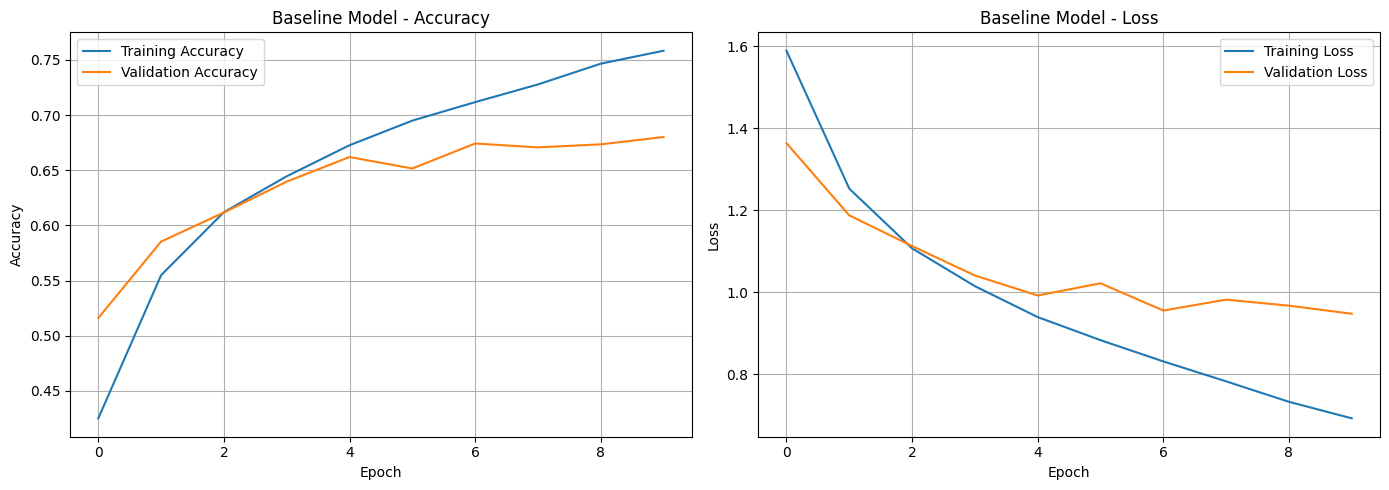

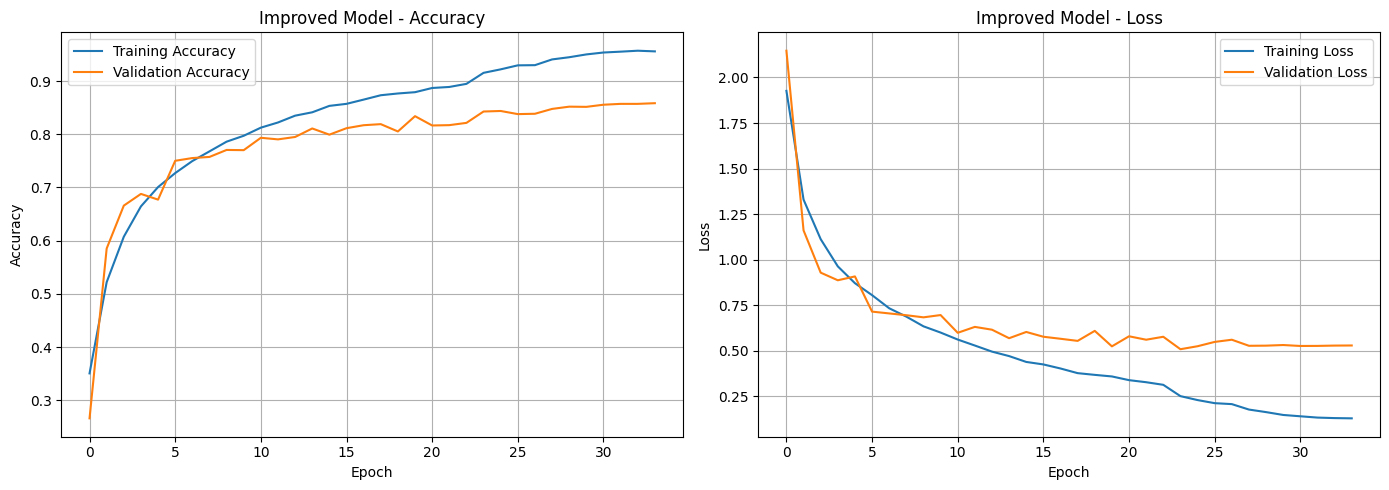

In [10]:
# ============================================================================
# STEP 7: Visualize Training History
# ============================================================================

def plot_history(history, title):
    """
    Plot training and validation accuracy/loss curves
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Plot accuracy
    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title(f'{title} - Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True)
    
    # Plot loss
    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title(f'{title} - Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

# Plot baseline model history
plot_history(baseline_history, 'Baseline Model')

# Plot improved model history
plot_history(improved_history, 'Improved Model')



Visualizing predictions on random test images...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


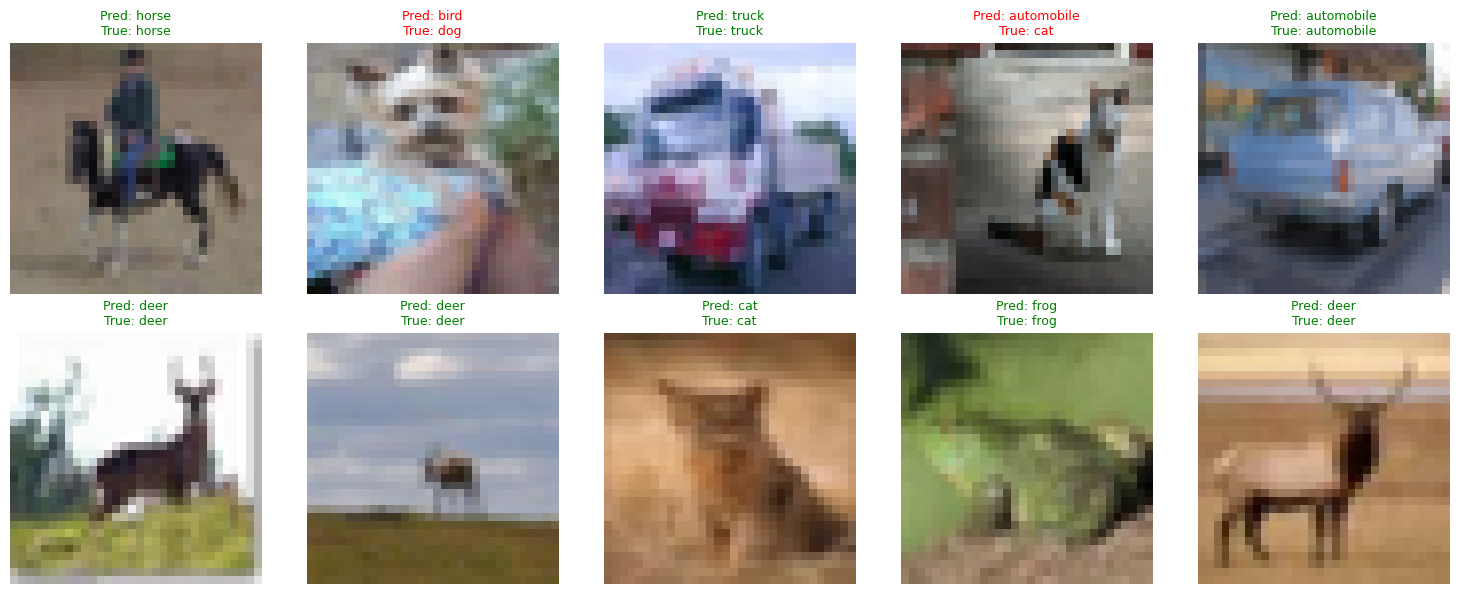

In [11]:
# ============================================================================
# STEP 8: Visualize Predictions
# ============================================================================

def visualize_predictions(model, X_test, y_test, class_names, num_images=10):
    """
    Visualize model predictions on random test images
    """
    # Get random indices
    indices = np.random.choice(len(X_test), num_images, replace=False)
    
    # Make predictions
    predictions = model.predict(X_test[indices])
    
    # Plot images with predictions
    plt.figure(figsize=(15, 6))
    for i, idx in enumerate(indices):
        plt.subplot(2, 5, i + 1)
        plt.imshow(X_test[idx])
        
        pred_class = np.argmax(predictions[i])
        true_class = np.argmax(y_test[idx])
        
        color = 'green' if pred_class == true_class else 'red'
        plt.title(f'Pred: {class_names[pred_class]}\nTrue: {class_names[true_class]}',
                 color=color, fontsize=9)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

print("\nVisualizing predictions on random test images...")
visualize_predictions(improved_model, X_test, y_test, class_names)
